<a href="https://colab.research.google.com/github/TobyW28/FTL-TRANS/blob/main/ftl_trans_t.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pytorch-transformers
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.8 MB/s eta 0:00:00


In [ ]:
pip install pytorch-pretrained-bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
!pip install dotmap

In [ ]:
import torch
from torch import nn
from torch.nn import init, Parameter
from torch.nn import CrossEntropyLoss, BCELoss, BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_pretrained_bert.optimization import BertAdam
from dotmap import DotMap
import six
import time
import copy
import math
#from file_utils import cached_path
import logging
MAX_LEN = 128

In [ ]:
import pandas as pd
train_df = pd.read_csv("/content/drive/My Drive/train_chunk.csv")
val_df = pd.read_csv("/content/drive/My Drive/val_chunk.csv")
test_df = pd.read_csv("/content/drive/My Drive/test_chunk.csv")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print("Number of GPU is {}".format(n_gpu))

torch.manual_seed(42)
if n_gpu > 0:
    torch.cuda.manual_seed_all(42)

Number of GPU is 1


In [ ]:
def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):
    """Pads sequences to the same length.

    This function transforms a list of
    `num_samples` sequences (lists of integers)
    into a 2D Numpy array of shape `(num_samples, num_timesteps)`.
    `num_timesteps` is either the `maxlen` argument if provided,
    or the length of the longest sequence otherwise.

    Sequences that are shorter than `num_timesteps`
    are padded with `value` at the end.

    Sequences longer than `num_timesteps` are truncated
    so that they fit the desired length.
    The position where padding or truncation happens is determined by
    the arguments `padding` and `truncating`, respectively.

    Pre-padding is the default.

    # Arguments
        sequences: List of lists, where each element is a sequence.
        maxlen: Int, maximum length of all sequences.
        dtype: Type of the output sequences.
            To pad sequences with variable length strings, you can use `object`.
        padding: String, 'pre' or 'post':
            pad either before or after each sequence.
        truncating: String, 'pre' or 'post':
            remove values from sequences larger than
            `maxlen`, either at the beginning or at the end of the sequences.
        value: Float or String, padding value.

    # Returns
        x: Numpy array with shape `(len(sequences), maxlen)`

    # Raises
        ValueError: In case of invalid values for `truncating` or `padding`,
            or in case of invalid shape for a `sequences` entry.
    """
    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` must be iterable.')
    num_samples = len(sequences)

    lengths = []
    for x in sequences:
        try:
            lengths.append(len(x))
        except TypeError:
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))

    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    is_dtype_str = np.issubdtype(dtype, np.str_) or np.issubdtype(dtype, np.unicode_)
    if isinstance(value, six.string_types) and dtype != object and not is_dtype_str:
        raise ValueError("`dtype` {} is not compatible with `value`'s type: {}\n"
                         "You should set `dtype=object` for variable length strings."
                         .format(dtype, type(value)))

    x = np.full((num_samples, maxlen) + sample_shape, value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" '
                             'not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s '
                             'is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x
def Tokenize_with_note_id_hour(df, max_length, tokenizer):
    labels = df.Label.values
    note_ids = df.Note_ID.values
    times = pd.to_datetime(df.charttime.values)
    times = times - times.min()
    times = times / pd.Timedelta(days=1)
    if 'TEXT' in df.columns:
        sen = df.TEXT.values
        labels = df.Label.values
        sen = ["[CLS] " + x + " [SEP]" for x in sen]
        tokenized_texts = [tokenizer.tokenize(x) for x in sen]
        print("First sentence tokenized")
        print(tokenized_texts[0])
        input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    else:
        assert 'Input_ID' in df.columns
        input_ids = df.Input_ID.apply(lambda x: x.split(' '))
        input_ids = input_ids.apply(lambda x: [int(i) for i in x])
        input_ids = input_ids.values
    input_ids = pad_sequences(input_ids, maxlen=max_length, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)
    return labels, input_ids, attention_masks, note_ids, times

def reorder_by_time(data):
    data.chartdate = pd.to_datetime(data.chartdate)
    data.charttime = pd.to_datetime(data.charttime)
    data.loc[data.charttime.isna(), 'charttime'] = data[data.charttime.isna()].chartdate + pd.Timedelta(hours=23,
                                                                                                        minutes=59,
                                                                                                        seconds=59)
    data = data.sort_values(by=['Adm_ID', 'charttime', 'Note_ID'])
    data.reset_index(inplace=True)
    return data


def concat_by_id_list_with_note_chunk_id_time(df, labels, inputs, masks, note_ids, times, str_len):
    final_labels, final_inputs, final_masks, final_note_ids, final_chunk_ids, final_times = [], [], [], [], [], []
    id_lists = df.Adm_ID.unique()
    for id in id_lists:
        id_ix = df.index[df.Adm_ID == id].to_list()
        final_inputs.append(inputs[id_ix])
        final_masks.append(masks[id_ix])
        final_labels.append(labels[id_ix].max())
        final_note_ids.append(note_ids[id_ix])
        final_chunk_ids.append(torch.tensor(list(range(len(id_ix)))[::-1]))
        final_times.append(torch.tensor(np.concatenate([np.zeros(1), np.diff(times[id_ix])])))
    return final_labels, final_inputs, final_masks, id_lists, final_note_ids, final_chunk_ids, final_times

def convert_note_ids(note_ids):
    new_dict = dict(zip(pd.Series(note_ids).unique(), range(len(pd.Series(note_ids).unique()))[::-1]))
    new_ids = [new_dict[i] for i in note_ids]
    return torch.tensor(new_ids)


def flat_accuracy(preds, labels):
    pred_flat = np.asarray([1 if i else 0 for i in (preds.flatten() >= 0.5)])
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 950054.82B/s]


In [ ]:
train_df = reorder_by_time(train_df)
val_df = reorder_by_time(val_df)
test_df = reorder_by_time(test_df)
train_labels, train_inputs, train_masks, train_note_ids, train_times = Tokenize_with_note_id_hour(train_df, MAX_LEN,
                                                                                                      tokenizer)
validation_labels, validation_inputs, validation_masks, validation_note_ids, validation_times = Tokenize_with_note_id_hour(
        val_df, MAX_LEN, tokenizer)
test_labels, test_inputs, test_masks, test_note_ids, test_times = Tokenize_with_note_id_hour(test_df, MAX_LEN,
                                                                                                 tokenizer)

In [ ]:

train_times

Float64Index([10918.840277777777, 10918.840277777777, 10918.882638888888,
               34736.19513888889,  34736.20347222222,  34736.20347222222,
               34736.20347222222,  34736.20347222222,  34736.20347222222,
               34736.30972222222,
              ...
              27770.473599537036, 27770.473599537036, 27770.473599537036,
              27770.473599537036, 27770.473599537036, 27770.473599537036,
              27770.473599537036, 27770.473599537036, 27770.473599537036,
              27770.473599537036],
             dtype='float64', length=227202)

In [ ]:

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)
train_times = torch.tensor(train_times)
validation_times = torch.tensor(validation_times)
test_times = torch.tensor(test_times)

In [ ]:
(train_labels, train_inputs,
     train_masks, train_ids,
     train_note_ids, train_chunk_ids, train_times) = concat_by_id_list_with_note_chunk_id_time(train_df, train_labels,
                                                                                               train_inputs,
                                                                                               train_masks,
                                                                                               train_note_ids,
                                                                                               train_times, MAX_LEN)
(validation_labels, validation_inputs,
     validation_masks, validation_ids,
     validation_note_ids, validation_chunk_ids,
     validation_times) = concat_by_id_list_with_note_chunk_id_time(val_df, validation_labels,
                                                                   validation_inputs, validation_masks,
                                                                   validation_note_ids, validation_times,
                                                                   MAX_LEN)
(test_labels, test_inputs,
     test_masks, test_ids,
     test_note_ids, test_chunk_ids, test_times) = concat_by_id_list_with_note_chunk_id_time(test_df, test_labels,
                                                                                            test_inputs, test_masks,
                                                                                            test_note_ids, test_times,
                                                                                            MAX_LEN)

In [ ]:
import json
import os
import json
import math
import logging
import tarfile
import tempfile
import shutil
import sys
from urllib.parse import urlparse
from pathlib import Path
import requests
import boto3
from functools import wraps
from hashlib import sha256
from botocore.exceptions import ClientError
PYTORCH_PRETRAINED_BERT_CACHE = Path(os.getenv('PYTORCH_PRETRAINED_BERT_CACHE',
                                                   Path.home() / '.pytorch_pretrained_bert'))
def url_to_filename(url, etag=None):
    """
    Convert `url` into a hashed filename in a repeatable way.
    If `etag` is specified, append its hash to the url's, delimited
    by a period.
    """
    url_bytes = url.encode('utf-8')
    url_hash = sha256(url_bytes)
    filename = url_hash.hexdigest()

    if etag:
        etag_bytes = etag.encode('utf-8')
        etag_hash = sha256(etag_bytes)
        filename += '.' + etag_hash.hexdigest()

    return filename


def filename_to_url(filename, cache_dir=None):
    """
    Return the url and etag (which may be ``None``) stored for `filename`.
    Raise ``EnvironmentError`` if `filename` or its stored metadata do not exist.
    """
    if cache_dir is None:
        cache_dir = PYTORCH_PRETRAINED_BERT_CACHE
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    cache_path = os.path.join(cache_dir, filename)
    if not os.path.exists(cache_path):
        raise EnvironmentError("file {} not found".format(cache_path))

    meta_path = cache_path + '.json'
    if not os.path.exists(meta_path):
        raise EnvironmentError("file {} not found".format(meta_path))

    with open(meta_path, encoding="utf-8") as meta_file:
        metadata = json.load(meta_file)
    url = metadata['url']
    etag = metadata['etag']

    return url, etag


def cached_path(url_or_filename, cache_dir=None):
    """
    Given something that might be a URL (or might be a local path),
    determine which. If it's a URL, download the file and cache it, and
    return the path to the cached file. If it's already a local path,
    make sure the file exists and then return the path.
    """
    if cache_dir is None:
        cache_dir = PYTORCH_PRETRAINED_BERT_CACHE
    if sys.version_info[0] == 3 and isinstance(url_or_filename, Path):
        url_or_filename = str(url_or_filename)
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    parsed = urlparse(url_or_filename)

    if parsed.scheme in ('http', 'https', 's3'):
        # URL, so get it from the cache (downloading if necessary)
        return get_from_cache(url_or_filename, cache_dir)
    elif os.path.exists(url_or_filename):
        # File, and it exists.
        return url_or_filename
    elif parsed.scheme == '':
        # File, but it doesn't exist.
        raise EnvironmentError("file {} not found".format(url_or_filename))
    else:
        # Something unknown
        raise ValueError("unable to parse {} as a URL or as a local path".format(url_or_filename))


def split_s3_path(url):
    """Split a full s3 path into the bucket name and path."""
    parsed = urlparse(url)
    if not parsed.netloc or not parsed.path:
        raise ValueError("bad s3 path {}".format(url))
    bucket_name = parsed.netloc
    s3_path = parsed.path
    # Remove '/' at beginning of path.
    if s3_path.startswith("/"):
        s3_path = s3_path[1:]
    return bucket_name, s3_path


def s3_request(func):
    """
    Wrapper function for s3 requests in order to create more helpful error
    messages.
    """

    @wraps(func)
    def wrapper(url, *args, **kwargs):
        try:
            return func(url, *args, **kwargs)
        except ClientError as exc:
            if int(exc.response["Error"]["Code"]) == 404:
                raise EnvironmentError("file {} not found".format(url))
            else:
                raise

    return wrapper


@s3_request
def s3_etag(url):
    """Check ETag on S3 object."""
    s3_resource = boto3.resource("s3")
    bucket_name, s3_path = split_s3_path(url)
    s3_object = s3_resource.Object(bucket_name, s3_path)
    return s3_object.e_tag


@s3_request
def s3_get(url, temp_file):
    """Pull a file directly from S3."""
    s3_resource = boto3.resource("s3")
    bucket_name, s3_path = split_s3_path(url)
    s3_resource.Bucket(bucket_name).download_fileobj(s3_path, temp_file)


def http_get(url, temp_file):
    req = requests.get(url, stream=True)
    content_length = req.headers.get('Content-Length')
    total = int(content_length) if content_length is not None else None
    progress = tqdm(unit="B", total=total)
    for chunk in req.iter_content(chunk_size=1024):
        if chunk: # filter out keep-alive new chunks
            progress.update(len(chunk))
            temp_file.write(chunk)
    progress.close()


def get_from_cache(url, cache_dir=None):
    """
    Given a URL, look for the corresponding dataset in the local cache.
    If it's not there, download it. Then return the path to the cached file.
    """
    if cache_dir is None:
        cache_dir = PYTORCH_PRETRAINED_BERT_CACHE
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    # Get eTag to add to filename, if it exists.
    if url.startswith("s3://"):
        etag = s3_etag(url)
    else:
        response = requests.head(url, allow_redirects=True)
        if response.status_code != 200:
            raise IOError("HEAD request failed for url {} with status code {}"
                          .format(url, response.status_code))
        etag = response.headers.get("ETag")

    filename = url_to_filename(url, etag)

    # get cache path to put the file
    cache_path = os.path.join(cache_dir, filename)

    if not os.path.exists(cache_path):
        # Download to temporary file, then copy to cache dir once finished.
        # Otherwise you get corrupt cache entries if the download gets interrupted.
        with tempfile.NamedTemporaryFile() as temp_file:
            logger.info("%s not found in cache, downloading to %s", url, temp_file.name)

            # GET file object
            if url.startswith("s3://"):
                s3_get(url, temp_file)
            else:
                http_get(url, temp_file)

            # we are copying the file before closing it, so flush to avoid truncation
            temp_file.flush()
            # shutil.copyfileobj() starts at the current position, so go to the start
            temp_file.seek(0)

            logger.info("copying %s to cache at %s", temp_file.name, cache_path)
            with open(cache_path, 'wb') as cache_file:
                shutil.copyfileobj(temp_file, cache_file)

            logger.info("creating metadata file for %s", cache_path)
            meta = {'url': url, 'etag': etag}
            meta_path = cache_path + '.json'
            with open(meta_path, 'w', encoding="utf-8") as meta_file:
                json.dump(meta, meta_file)

            logger.info("removing temp file %s", temp_file.name)

    return cache_path


def read_set_from_file(filename):
    '''
    Extract a de-duped collection (set) of text from a file.
    Expected file format is one item per line.
    '''
    collection = set()
    with open(filename, 'r', encoding='utf-8') as file_:
        for line in file_:
            collection.add(line.rstrip())
    return collection


def get_file_extension(path, dot=True, lower=True):
    ext = os.path.splitext(path)[1]
    ext = ext if dot else ext[1:]
    return ext.lower() if lower else ext

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

PRETRAINED_MODEL_ARCHIVE_MAP = {
    'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz",
    'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased.tar.gz",
    'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz",
    'bert-base-multilingual': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual.tar.gz",
    'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese.tar.gz",
}
CONFIG_NAME = 'bert_config.json'
WEIGHTS_NAME = 'pytorch_model.bin'

def gelu(x):
    """Implementation of the gelu activation function.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": gelu, "relu": torch.nn.functional.relu, "swish": swish}


class BertConfig(object):
    """Configuration class to store the configuration of a `BertModel`.
    """
    def __init__(self,
                 vocab_size_or_config_json_file,
                 hidden_size=768,
                 num_hidden_layers=12,
                 num_attention_heads=12,
                 intermediate_size=3072,
                 hidden_act="gelu",
                 hidden_dropout_prob=0.1,
                 attention_probs_dropout_prob=0.1,
                 max_position_embeddings=512,
                 type_vocab_size=2,
                 initializer_range=0.02):
        """Constructs BertConfig.

        Args:
            vocab_size_or_config_json_file: Vocabulary size of `inputs_ids` in `BertModel`.
            hidden_size: Size of the encoder layers and the pooler layer.
            num_hidden_layers: Number of hidden layers in the Transformer encoder.
            num_attention_heads: Number of attention heads for each attention layer in
                the Transformer encoder.
            intermediate_size: The size of the "intermediate" (i.e., feed-forward)
                layer in the Transformer encoder.
            hidden_act: The non-linear activation function (function or string) in the
                encoder and pooler. If string, "gelu", "relu" and "swish" are supported.
            hidden_dropout_prob: The dropout probabilitiy for all fully connected
                layers in the embeddings, encoder, and pooler.
            attention_probs_dropout_prob: The dropout ratio for the attention
                probabilities.
            max_position_embeddings: The maximum sequence length that this model might
                ever be used with. Typically set this to something large just in case
                (e.g., 512 or 1024 or 2048).
            type_vocab_size: The vocabulary size of the `token_type_ids` passed into
                `BertModel`.
            initializer_range: The sttdev of the truncated_normal_initializer for
                initializing all weight matrices.
        """
        if isinstance(vocab_size_or_config_json_file, str):
            with open(vocab_size_or_config_json_file, "r") as reader:
                json_config = json.loads(reader.read())
            for key, value in json_config.items():
                self.__dict__[key] = value
        elif isinstance(vocab_size_or_config_json_file, int):
            self.vocab_size = vocab_size_or_config_json_file
            self.hidden_size = hidden_size
            self.num_hidden_layers = num_hidden_layers
            self.num_attention_heads = num_attention_heads
            self.hidden_act = hidden_act
            self.intermediate_size = intermediate_size
            self.hidden_dropout_prob = hidden_dropout_prob
            self.attention_probs_dropout_prob = attention_probs_dropout_prob
            self.max_position_embeddings = max_position_embeddings
            self.type_vocab_size = type_vocab_size
            self.initializer_range = initializer_range
        else:
            raise ValueError("First argument must be either a vocabulary size (int)"
                             "or the path to a pretrained model config file (str)")

    @classmethod
    def from_dict(cls, json_object):
        """Constructs a `BertConfig` from a Python dictionary of parameters."""
        config = BertConfig(vocab_size_or_config_json_file=-1)
        for key, value in json_object.items():
            config.__dict__[key] = value
        return config

    @classmethod
    def from_json_file(cls, json_file):
        """Constructs a `BertConfig` from a json file of parameters."""
        with open(json_file, "r") as reader:
            text = reader.read()
        return cls.from_dict(json.loads(text))

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"



class BertLayerNorm(nn.Module):
    def __init__(self, config, variance_epsilon=1e-12):
        """Construct a layernorm module in the TF style (epsilon inside the square root).
        """
        super(BertLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(config.hidden_size))
        self.beta = nn.Parameter(torch.zeros(config.hidden_size))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads))
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        return context_layer

class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

class BertAttention(nn.Module):
    def __init__(self, config):
        super(BertAttention, self).__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, attention_mask):
        self_output = self.self(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output


class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = ACT2FN[config.hidden_act] \
            if isinstance(config.hidden_act, str) else config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class BertOutput(nn.Module):
    def __init__(self, config):
        super(BertOutput, self).__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states
class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings.
    """
    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = BertLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids, token_type_ids=None):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

class BertLayer(nn.Module):
    def __init__(self, config):
        super(BertLayer, self).__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask):
        attention_output = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

class BertEncoder(nn.Module):
    def __init__(self, config):
        super(BertEncoder, self).__init__()
        layer = BertLayer(config)
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True):
        all_encoder_layers = []
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states, attention_mask)
            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)
        return all_encoder_layers

class BertPooler(nn.Module):
    def __init__(self, config):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

class PreTrainedBertModel(nn.Module):
    """ An abstract class to handle weights initialization and
        a simple interface for dowloading and loading pretrained models.
    """
    def __init__(self, config, *inputs, **kwargs):
        super(PreTrainedBertModel, self).__init__()
        if not isinstance(config, BertConfig):
            raise ValueError(
                "Parameter config in `{}(config)` should be an instance of class `BertConfig`. "
                "To create a model from a Google pretrained model use "
                "`model = {}.from_pretrained(PRETRAINED_MODEL_NAME)`".format(
                    self.__class__.__name__, self.__class__.__name__
                ))
        self.config = config

    def init_bert_weights(self, module):
        """ Initialize the weights.
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.beta.data.normal_(mean=0.0, std=self.config.initializer_range)
            module.gamma.data.normal_(mean=0.0, std=self.config.initializer_range)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    @classmethod
    def from_pretrained(cls, pretrained_model_name, *inputs, **kwargs):
        """
        Instantiate a PreTrainedBertModel from a pre-trained model file.
        Download and cache the pre-trained model file if needed.

        Params:
            pretrained_model_name: either:
                - a str with the name of a pre-trained model to load selected in the list of:
                    . `bert-base-uncased`
                    . `bert-large-uncased`
                    . `bert-base-cased`
                    . `bert-base-multilingual`
                    . `bert-base-chinese`
                - a path or url to a pretrained model archive containing:
                    . `bert_config.json` a configuration file for the model
                    . `pytorch_model.bin` a PyTorch dump of a BertForPreTraining instance
            *inputs, **kwargs: additional input for the specific Bert class
                (ex: num_labels for BertForSequenceClassification)
        """
        if pretrained_model_name in PRETRAINED_MODEL_ARCHIVE_MAP:
            archive_file = PRETRAINED_MODEL_ARCHIVE_MAP[pretrained_model_name]
        else:
            archive_file = pretrained_model_name
        # redirect to the cache, if necessary
        try:
            resolved_archive_file = cached_path(archive_file)
        except FileNotFoundError:
            logger.error(
                "Model name '{}' was not found in model name list ({}). "
                "We assumed '{}' was a path or url but couldn't find any file "
                "associated to this path or url.".format(
                    pretrained_model_name,
                    ', '.join(PRETRAINED_MODEL_ARCHIVE_MAP.keys()),
                    pretrained_model_name))
            return None
        if resolved_archive_file == archive_file:
            logger.info("loading archive file {}".format(archive_file))
        else:
            logger.info("loading archive file {} from cache at {}".format(
                archive_file, resolved_archive_file))
        tempdir = None
        if os.path.isdir(resolved_archive_file):
            serialization_dir = resolved_archive_file
        else:
            # Extract archive to temp dir
            tempdir = tempfile.mkdtemp()
            logger.info("extracting archive file {} to temp dir {}".format(
                resolved_archive_file, tempdir))
            with tarfile.open(resolved_archive_file, 'r:gz') as archive:
                archive.extractall(tempdir)
            serialization_dir = tempdir
        # Load config
        config_file = os.path.join(serialization_dir, CONFIG_NAME)
        config = BertConfig.from_json_file(config_file)
        logger.info("Model config {}".format(config))
        # Instantiate model.
        model = cls(config, *inputs, **kwargs)
        weights_path = os.path.join(serialization_dir, WEIGHTS_NAME)
        state_dict = torch.load(weights_path, map_location = 'cpu')

        missing_keys = []
        unexpected_keys = []
        error_msgs = []
        # copy state_dict so _load_from_state_dict can modify it
        metadata = getattr(state_dict, '_metadata', None)
        state_dict = state_dict.copy()
        if metadata is not None:
            state_dict._metadata = metadata

        def load(module, prefix=''):
            local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
            module._load_from_state_dict(
                state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')
        load(model, prefix='' if hasattr(model, 'bert') else 'bert.')
        if len(missing_keys) > 0:
            logger.info("Weights of {} not initialized from pretrained model: {}".format(
                model.__class__.__name__, missing_keys))
        if len(unexpected_keys) > 0:
            logger.info("Weights from pretrained model not used in {}: {}".format(
                model.__class__.__name__, unexpected_keys))
        if tempdir:
            # Clean up temp dir
            shutil.rmtree(tempdir)
        return model

class BertModel(PreTrainedBertModel):
    """BERT model ("Bidirectional Embedding Representations from a Transformer").

    Params:
        config: a BertConfig class instance with the configuration to build a new model

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `output_all_encoded_layers`: boolean which controls the content of the `encoded_layers` output as described below. Default: `True`.

    Outputs: Tuple of (encoded_layers, pooled_output)
        `encoded_layers`: controled by `output_all_encoded_layers` argument:
            - `output_all_encoded_layers=True`: outputs a list of the full sequences of encoded-hidden-states at the end
                of each attention block (i.e. 12 full sequences for BERT-base, 24 for BERT-large), each
                encoded-hidden-state is a torch.FloatTensor of size [batch_size, sequence_length, hidden_size],
            - `output_all_encoded_layers=False`: outputs only the full sequence of hidden-states corresponding
                to the last attention block,
        `pooled_output`: a torch.FloatTensor of size [batch_size, hidden_size] which is the output of a
            classifier pretrained on top of the hidden state associated to the first character of the
            input (`CLF`) to train on the Next-Sentence task (see BERT's paper).

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 2, 0]])

    config = modeling.BertConfig(vocab_size=32000, hidden_size=512,
        num_hidden_layers=8, num_attention_heads=6, intermediate_size=1024)

    model = modeling.BertModel(config=config)
    all_encoder_layers, pooled_output = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, output_all_encoded_layers=True):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
        # this attention mask is more simple than the triangular masking of causal attention
        # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(input_ids, token_type_ids)
        encoded_layers = self.encoder(embedding_output,
                                      extended_attention_mask,
                                      output_all_encoded_layers=output_all_encoded_layers)
        sequence_output = encoded_layers[-1]
        pooled_output = self.pooler(sequence_output)
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
        return encoded_layers, pooled_output

In [ ]:
class PatientLevelEmbedding(nn.Module):
    def __init__(self, config):
        super(PatientLevelEmbedding, self).__init__()
        self.config = config
        assert self.config.embed_mode in ["all", "note", "chunk", "no"]
        if self.config.embed_mode == "all":
            self.note_embedding = nn.Embedding(self.config.max_note_position_embedding, self.config.hidden_size)
            self.chunk_embedding = nn.Embedding(self.config.max_chunk_position_embedding, self.config.hidden_size)
            self.combine_embed_rep = nn.Linear(self.config.hidden_size * 3, self.config.hidden_size)
        elif self.config.embed_mode == "note":
            self.note_embedding = nn.Embedding(self.config.max_note_position_embedding, self.config.hidden_size)
            self.combine_embed_rep = nn.Linear(self.config.hidden_size * 2, self.config.hidden_size)
        elif self.config.embed_mode == "chunk":
            self.chunk_embedding = nn.Embedding(self.config.max_chunk_position_embedding, self.config.hidden_size)
            self.combine_embed_rep = nn.Linear(self.config.hidden_size * 2, self.config.hidden_size)
        else:
            pass
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, inputs, new_note_ids=None, new_chunk_ids=None):
        if self.config.embed_mode == "all":
            note_embeds = self.note_embedding(new_note_ids)
            chunk_embeds = self.chunk_embedding(new_chunk_ids)
            output = self.combine_embed_rep(torch.cat((inputs, note_embeds, chunk_embeds), 2))
        elif self.config.embed_mode == "note":
            note_embeds = self.note_embedding(new_note_ids)
            output = self.combine_embed_rep(torch.cat((inputs, note_embeds), 2))
        elif self.config.embed_mode == "chunk":
            chunk_embeds = self.chunk_embedding(new_chunk_ids)
            output = self.combine_embed_rep(torch.cat((inputs, chunk_embeds), 2))
        elif self.config.embed_mode == "no":
            output = inputs
        else:
            raise ValueError("The embed mode: {} is not supported".format(self.config.embed_mode))
        if self.config.embed_mode != "no":
            output = self.LayerNorm(output)
            output = self.dropout(output)
        return output

class SelfDefineBert(nn.Module):
    def __init__(self):
        super(SelfDefineBert, self).__init__()

    def init_weights(self, module):
        """ Initialize the weights """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

class FTLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, config, batch_first=True, bidirectional=True):
        super(FTLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.c1 = torch.Tensor([1]).float()
        self.c2 = torch.Tensor([np.e]).float()
        self.c3 = torch.Tensor([0.]).float()
        self.ones = torch.ones([1, self.hidden_size]).float()
        self.register_buffer('c1_const', self.c1)
        self.register_buffer('c2_const', self.c2)
        self.register_buffer('c3_const', self.c3)
        self.register_buffer("ones_const", self.ones)
        # Input Gate Parameter
        self.Wi = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Ui = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bi = Parameter(torch.zeros(self.hidden_size))
        # Forget Gate Parameter
        self.Wf = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Uf = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bf = Parameter(torch.zeros(self.hidden_size))
        # Output Gate Parameter
        self.Wog = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Uog = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bog = Parameter(torch.zeros(self.hidden_size))
        # Cell Layer Parameter
        self.Wc = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Uc = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bc = Parameter(torch.zeros(self.hidden_size))
        # Decomposition Layer Parameter
        self.W_decomp = Parameter(
            torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.b_decomp = Parameter(torch.zeros(self.hidden_size))
        # Decay Parameter
        self.W_decay_1 = Parameter(torch.tensor([[0.33]]))
        self.W_decay_2 = Parameter(torch.tensor([[0.33]]))
        self.W_decay_3 = Parameter(torch.tensor([[0.33]]))
        self.a = Parameter(torch.tensor([1.0]))
        self.b = Parameter(torch.tensor([1.0]))
        self.m = Parameter(torch.tensor([0.02]))
        self.k = Parameter(torch.tensor([2.9]))
        self.d = Parameter(torch.tensor([4.5]))
        self.n = Parameter(torch.tensor([2.5]))

    def FTLSTM_unit(self, prev_hidden_memory, inputs, times):
        prev_hidden_state, prev_cell = prev_hidden_memory
        x = inputs
        t = times
        T = self.map_elapse_time(t)
        C_ST = torch.tanh(torch.matmul(prev_cell, self.W_decomp) + self.b_decomp)
        C_ST_dis = torch.mul(T, C_ST)
        prev_cell = prev_cell - C_ST + C_ST_dis

        # Input Gate
        i = torch.sigmoid(torch.matmul(x, self.Wi) +
                          torch.matmul(prev_hidden_state, self.Ui) + self.bi)
        # Forget Gate
        f = torch.sigmoid(torch.matmul(x, self.Wf) +
                          torch.matmul(prev_hidden_state, self.Uf) + self.bf)
        # Output Gate
        o = torch.sigmoid(torch.matmul(x, self.Wog) +
                          torch.matmul(prev_hidden_state, self.Uog) + self.bog)
        # Candidate Memory Cell
        C = torch.sigmoid(torch.matmul(x, self.Wc) +
                          torch.matmul(prev_hidden_state, self.Uc) + self.bc)
        # Current Memory Cell
        Ct = f * prev_cell + i * C

        # Current Hidden State
        current_hidden_state = o * torch.tanh(Ct)

        return current_hidden_state, Ct

    def map_elapse_time(self, t):
        T_1 = torch.div(self.c1_const, torch.mul(self.a, torch.pow(t, self.b)))
        T_2 = self.k - torch.mul(self.m, t)
        T_3 = torch.div(self.c1_const, (self.c1_const + torch.pow(torch.div(t, self.d), self.n)))
        T = torch.mul(self.W_decay_1, T_1) + torch.mul(self.W_decay_2, T_2) + torch.mul(self.W_decay_3, T_3)
        T = torch.max(T, self.c3_const)
        T = torch.min(T, self.c1_const)
        T = torch.matmul(T, self.ones_const)
        return T

    def forward(self, inputs, times):
        device = inputs.device
        if self.batch_first:
            batch_size = inputs.size()[0]
            inputs = inputs.permute(1, 0, 2)
            times = times.transpose(0, 1)
        else:
            batch_size = inputs.size()[1]
        prev_hidden = torch.zeros((batch_size, self.hidden_size), device=device)
        prev_cell = torch.zeros((batch_size, self.hidden_size), device=device)
        seq_len = inputs.size()[0]
        hidden_his = []
        for i in range(seq_len):
            prev_hidden, prev_cell = self.FTLSTM_unit((prev_hidden, prev_cell), inputs[i], times[i])
            hidden_his.append(prev_hidden)
        hidden_his = torch.stack(hidden_his)
        if self.bidirectional:
            second_hidden = torch.zeros((batch_size, self.hidden_size), device=device)
            second_cell = torch.zeros((batch_size, self.hidden_size), device=device)
            second_inputs = torch.flip(inputs, [0])
            second_times = torch.flip(times, [0])
            second_hidden_his = []
            for i in range(seq_len):
                if i == 0:
                    time = times[i]
                else:
                    time = second_times[i-1]
                second_hidden, second_cell = self.FTLSTM_unit((second_hidden, second_cell), second_inputs[i], time)
                second_hidden_his.append(second_hidden)
            second_hidden_his = torch.stack(second_hidden_his)
            hidden_his = torch.cat((hidden_his, second_hidden_his), dim=2)
            prev_hidden = torch.cat((prev_hidden, second_hidden), dim=1)
            prev_cell = torch.cat((prev_cell, second_cell), dim=1)
        if self.batch_first:
            hidden_his = hidden_his.permute(1, 0, 2)
        return hidden_his, (prev_hidden, prev_cell)

class FTLSTMLayer(SelfDefineBert):

    def __init__(self, config, num_labels):
        super(FTLSTMLayer, self).__init__()
        self.config = config
        self.ftlstm = FTLSTM(self.config.hidden_size,
                           self.config.hidden_size // 2,
                           self.config,
                           batch_first=True,
                           bidirectional=True)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.embeddings = PatientLevelEmbedding(config)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

        self.apply(self.init_weights)

    def forward(self, inputs, times, new_note_ids=None, new_chunk_ids=None, labels=None):
        new_input = self.embeddings(inputs, new_note_ids, new_chunk_ids)
        lstm_output, hidden = self.ftlstm(new_input, times.float())
        loss_fct = BCEWithLogitsLoss()
        drop_input = lstm_output[0, -1, :]
        class_input = self.dropout(drop_input)
        logits = self.classifier(class_input)
        logits = torch.where(torch.isnan(logits), torch.zeros_like(logits), logits)
        logits = torch.where(torch.isinf(logits), torch.zeros_like(logits), logits)
        pred = torch.sigmoid(logits)
        pred = torch.where(torch.isnan(pred), torch.zeros_like(pred), pred)
        pred = torch.where(torch.isinf(pred), torch.zeros_like(pred), pred)
        if labels is not None:
            loss = loss_fct(logits, labels.float().view(1))
            return loss, pred
        else:
            return pred

In [ ]:
def time_batch_generator(max_len, input_ids, labels, masks, note_ids, chunk_ids, times=None):
    """batch generator with note_id, chunk_id and time
    """
    size = len(input_ids)
    indices = np.arange(size)
    np.random.shuffle(indices)

    i = 0
    while True:
        if i < size:
            if times is not None:
                yield input_ids[indices[i]][-max_len:, :], labels[indices[i]], masks[indices[i]][-max_len:, :], \
                      note_ids[indices[i]][-max_len:], chunk_ids[indices[i]][-max_len:], times[indices[i]][-max_len:]
            else:
                yield input_ids[indices[i]][-max_len:, :], labels[indices[i]], masks[indices[i]][-max_len:, :], \
                      note_ids[indices[i]][-max_len:], chunk_ids[indices[i]][-max_len:]
            i += 1
        else:
            i = 0
            indices = np.arange(size)
            np.random.shuffle(indices)
            continue

In [ ]:
config = DotMap()
config.hidden_dropout_prob = 0.1
config.layer_norm_eps = 1e-12
config.initializer_range = 0.02
config.max_note_position_embedding = 1000
config.max_chunk_position_embedding = 1000
config.embed_mode = 'all'
config.layer_norm_eps = 1e-12
config.hidden_size = 768
config.lstm_layers = 1

config.task_name = 'FTL-Trans_Prediction'

In [ ]:
gradient_accumulation_steps = 1
num_train_epochs = 3

DotMap(hidden_dropout_prob=0.1, layer_norm_eps=1e-12, initializer_range=0.02, max_note_position_embedding=1000, max_chunk_position_embedding=1000, embed_mode='all', hidden_size=768, lstm_layers=1, task_name='FTL-Trans_Prediction', _ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1519.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
Epoch: 100%|██████████| 3/3 [1:33:03<00:00, 1861.32s/it]


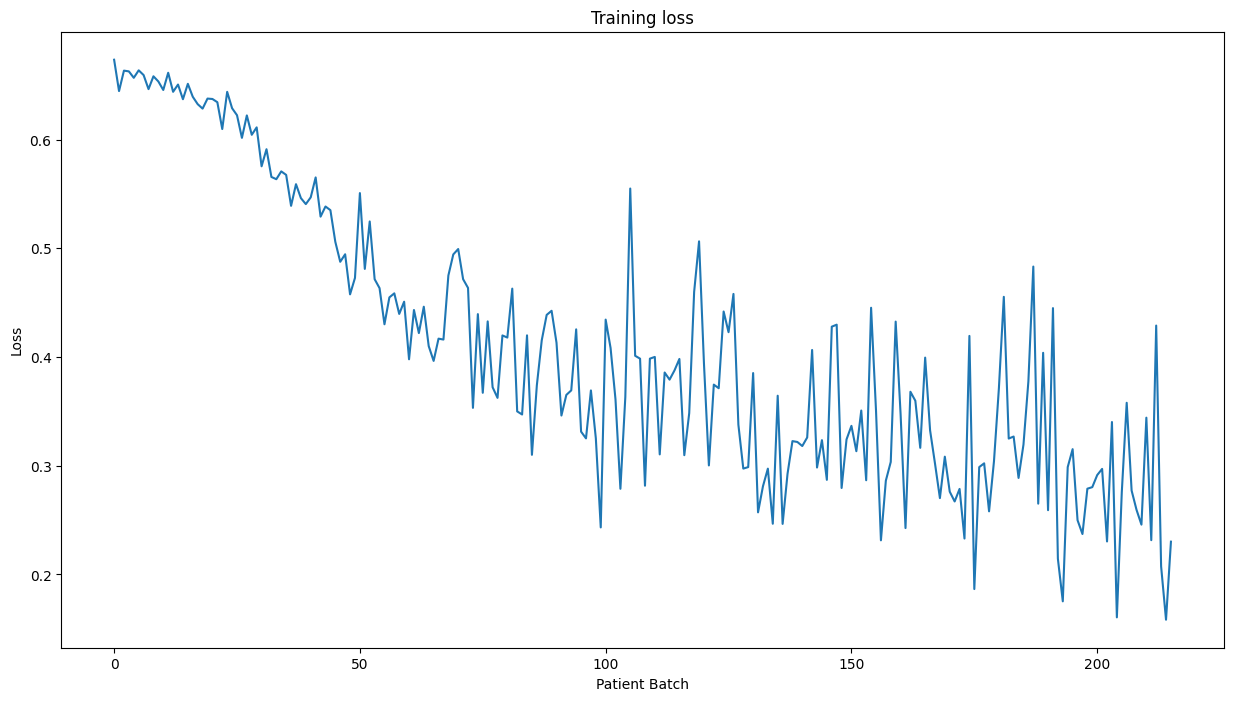

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')
model.to(device)

lstm_layer = FTLSTMLayer(config=config, num_labels=1)
lstm_layer.to(device)

if n_gpu > 1:
    model = torch.nn.DataParallel(model)
    lstm_layer = torch.nn.DataParallel(lstm_layer)
param_optimizer = list(model.named_parameters()) #+ list(lstm_layer.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]

num_train_steps = int(
    len(train_labels) / gradient_accumulation_steps * num_train_epochs)

optimizer = BertAdam(optimizer_grouped_parameters,
                         lr=2e-5,
                         warmup=0.1,
                         t_total=num_train_steps)
start = time.time()
    # Store our loss and accuracy for plotting
train_loss_set = []

    # Number of training epochs (authors recommend between 2 and 4)
epochs = num_train_epochs

train_batch_generator = time_batch_generator(32, train_inputs, train_labels, train_masks,
                                                 train_note_ids, train_chunk_ids, train_times)
validation_batch_generator = time_batch_generator(32, validation_inputs, validation_labels,
                                                      validation_masks, validation_note_ids, validation_chunk_ids,
                                                      validation_times)

with torch.autograd.set_detect_anomaly(False):
    for epoch in trange(epochs, desc="Epoch"):

            # Training

            # Set our model to training mode (as opposed to evaluation mode)
        model.train()
        lstm_layer.train()

            # Tracking variables
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

            # Train the data for one epoch
        tr_ids_num = len(train_ids)
        tr_batch_loss = []
        for step in range(tr_ids_num):
            b_input_ids, b_labels, b_input_mask, b_note_ids, b_chunk_ids, b_times = next(train_batch_generator)
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_new_note_ids = convert_note_ids(b_note_ids).to(device)
            b_chunk_ids = b_chunk_ids.unsqueeze(0).to(device)
            b_labels = b_labels.to(device)
            b_labels.resize_((1))
            _, whole_output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            whole_input = whole_output.unsqueeze(0)
            b_new_note_ids = b_new_note_ids.unsqueeze(0)
            b_times = b_times.unsqueeze(0).to(device)
            loss, pred = lstm_layer(whole_input, b_times, b_new_note_ids, b_chunk_ids, b_labels)

            if n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu.
            tr_batch_loss.append(loss.item())

                # Backward pass
            loss.backward()
                # Update parameters and take a step using the computed gradient
            if (step + 1) % 32 == 0:
                optimizer.step()
                optimizer.zero_grad()
                train_loss_set.append(np.mean(tr_batch_loss))
                tr_batch_loss = []
                # Update tracking variables
            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1

            # Validation

            # Put model in evaluation mode to evaluate loss on the validation set
        model.eval()
        lstm_layer.eval()

            # Tracking variables
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
            # Evaluate data for one epoch
        ev_ids_num = len(validation_ids)
        for step in range(ev_ids_num):
            with torch.no_grad():
                b_input_ids, b_labels, b_input_mask, b_note_ids, b_chunk_ids, b_times = next(
                        validation_batch_generator)
                b_input_ids = b_input_ids.to(device)
                b_input_mask = b_input_mask.to(device)
                b_new_note_ids = convert_note_ids(b_note_ids).to(device)
                b_chunk_ids = b_chunk_ids.unsqueeze(0).to(device)
                b_labels.resize_((1))
                _, whole_output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                whole_input = whole_output.unsqueeze(0)
                b_new_note_ids = b_new_note_ids.unsqueeze(0)
                b_times = b_times.unsqueeze(0).to(device)
                pred = lstm_layer(whole_input, b_times, b_new_note_ids, b_chunk_ids).detach().cpu().numpy()
            label_ids = b_labels.numpy()
            tmp_eval_accuracy = flat_accuracy(pred, label_ids)
            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1

            #if n_gpu > 1:
            #        torch.save({
            #            'epoch': epoch,
            #            'model_state_dict': model.module.state_dict(),
            #            'lstm_layer_state_dict': lstm_layer.module.state_dict(),
            #            'optimizer_state_dict': optimizer.state_dict(),
            #            'loss': loss,
            #        },
            #            output_checkpoints_path)

end = time.time()



fig1 = plt.figure(figsize=(15, 8))
plt.title("Training loss")
plt.xlabel("Patient Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)



In [ ]:
model.eval()
lstm_layer.eval()

    # Tracking variables
predictions, true_labels = [], []

    # Predict
te_ids_num = len(test_ids)
for step in range(te_ids_num):
    b_input_ids = test_inputs[step][-32:, :].to(device)
    b_input_mask = test_masks[step][-32:, :].to(device)
    b_note_ids = test_note_ids[step][-32:]
    b_new_note_ids = convert_note_ids(b_note_ids).to(device)
    b_chunk_ids = test_chunk_ids[step][-32:].unsqueeze(0).to(device)
    b_labels = test_labels[step]
    b_labels.resize_((1))
    with torch.no_grad():
        _, whole_output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        whole_input = whole_output.unsqueeze(0)
        b_new_note_ids = b_new_note_ids.unsqueeze(0)
        b_times = test_times[step][-32:].unsqueeze(0).to(device)
        pred = lstm_layer(whole_input, b_times, b_new_note_ids, b_chunk_ids).detach().cpu().numpy()
    label_ids = b_labels.numpy()[0]
    predictions.append(pred)
    true_labels.append(label_ids)

    # Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_logits = [item for sublist in predictions for item in sublist]
flat_predictions = np.asarray([1 if i else 0 for i in (np.array(flat_logits) >= 0.5)])
flat_true_labels = np.asarray(true_labels)

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, \
    auc, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score

def model_auc(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    return auc_score, fpr, tpr, thresholds

def model_aupr(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    aupr_score = auc(recall, precision)
    return aupr_score, precision, recall, thresholds

def write_performance(flat_true_labels, flat_predictions, flat_logits, config):
    test_accuracy = accuracy_score(flat_true_labels, flat_predictions)

    test_f1 = f1_score(flat_true_labels, flat_predictions, average='binary')

    test_prec = precision_score(flat_true_labels, flat_predictions, average='binary')

    test_rec = recall_score(flat_true_labels, flat_predictions, average='binary')

    test_auc, _, _, _ = model_auc(flat_true_labels, flat_logits)

    test_mc = matthews_corrcoef(flat_true_labels, flat_predictions)

    test_aupr, _, _, _ = model_aupr(flat_true_labels, flat_logits)

    test_msl = 128

    test_seed = 42

    test_time = time.ctime()

    exp_path = "{}_{}_{}.csv".format(config.task_name, config.embed_mode, test_msl)

    header = "Len,Dir,Seed,Accuracy,F1_Score,Precision,Recall,AUC,MCC,AUPR,Time"
    content = "{},{},{},{},{},{},{},{},{},{},{}".format(test_msl,
                                                        test_seed,
                                                        test_accuracy,
                                                        test_f1,
                                                        test_prec,
                                                        test_rec,
                                                        test_auc,
                                                        test_mc,
                                                        test_aupr,
                                                        test_time)

    print(content)




In [ ]:
test_accuracy = accuracy_score(flat_true_labels, flat_predictions)

test_f1 = f1_score(flat_true_labels, flat_predictions, average='binary')

test_prec = precision_score(flat_true_labels, flat_predictions, average='binary')

test_rec = recall_score(flat_true_labels, flat_predictions, average='binary')

test_auc, _, _, _ = model_auc(flat_true_labels, flat_logits)

test_mc = matthews_corrcoef(flat_true_labels, flat_predictions)

test_aupr, _, _, _ = model_aupr(flat_true_labels, flat_logits)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test_auc



0.9516448672215616